## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [87]:
### Useful routines for preparing data
import numpy as np
import pandas as pd
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

file = pd.read_csv('data/gt.csv')
face_points = file[file.columns[1:]]

def load_imgs_and_keypoints(dirname='data'):
    # Write your code for loading images and points here
    data = pd.read_csv(dirname + '/gt.csv')
    N = data.shape[0]
    points_arr = np.array(data[data.columns[1:]].as_matrix(), dtype=np.float32)
    points = np.zeros_like(points_arr, dtype=np.float32)
    print (points_arr.shape, points.shape)
#     print (len(points_arr[1,:]))
    imgs = np.zeros((N, 100, 100, 3)) #fetching a size of 100 * 100 for image scaling
    #scaling process
    for i in range(N):
        img = imread(dirname + '/images/' + data.filename[i])
        w = img.shape[1]
        h = img.shape[0]
        points[i,:] = points_arr[i,:] / np.tile([w,h], 14) - 0.5
        img = resize(img, (100,100,3))
        imgs[i,:,:,:] = img
    return imgs, points

imgs, points = load_imgs_and_keypoints()

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(6000, 28) (6000, 28)
28


array([-0.3053435 , -0.3053435 , -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480915, -0.30152673, -0.24045801, -0.20610687,
       -0.17557251, -0.21374045, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267175, -0.19847329,  0.23664123, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412213,  0.03435114,
        0.1870229 ,  0.14122137,  0.18320611], dtype=float32)

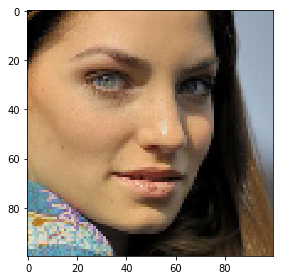

In [4]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

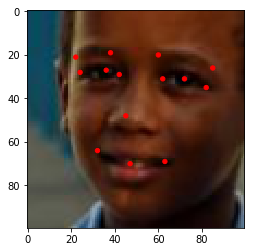

In [5]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(img)
    
    points_int = np.clip(np.array((points+0.5)*100, dtype=np.int32), 0, 99) #points vector
    
    for i in range(14):
        c = Circle((points_int[2*i], points_int[2*i+1]), radius=1, color='red')
        ax.add_patch(c)
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [6]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

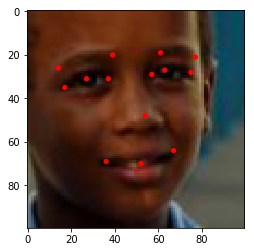

In [7]:
def flip_img(img, points):
    # Write your code for flipping here
    flip_image = img[:,::-1,:]
    
    flip_points = np.copy(points)
    
    for i in range(14):
        flip_points[2*i] = -points[2*i]
    return flip_image, flip_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [8]:
# Write your code here

n = imgs_train.shape[0]

aug_imgs_train = np.zeros((2*n, 100, 100, 3))
aug_points_train = np.zeros((2*n, 28))

for i in range(n):
    aug_imgs_train[2*i] = imgs_train[i]
    aug_points_train[2*i] = points_train[i]
    
    f_img, f_points = flip_img(imgs_train[i], points_train[i]) #flipping all 'count' number of images
    
    aug_imgs_train[2*i+1] = f_img
    aug_points_train[2*i+1] = f_points

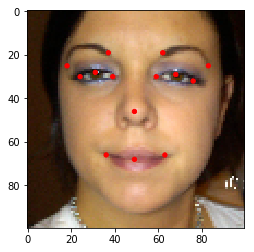

In [9]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

In [10]:
print (len(aug_imgs_train), len(aug_points_train))

10800 10800


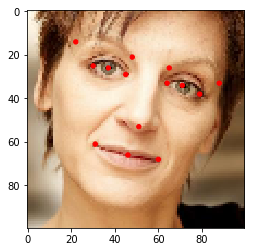

In [11]:
from random import randint
i = randint(0, 10800)
visualize_points(aug_imgs_train[i], aug_points_train[i])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [78]:
import keras.backend.tensorflow_backend as K

K.clear_session()

In [79]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential()
# Define here your model

model.add(Conv2D(filters=32,  kernel_size=(3,3), padding='valid', activation='relu', input_shape=aug_imgs_train[1].shape))
model.add(Conv2D(filters=32,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=64,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=128,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=256,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=28))



Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [80]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
early = EarlyStopping(monitor='val_loss',
                      min_delta=0.001,
                      patience=6, verbose=1,
                      mode='min')

# sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mse',
              optimizer=Adam(lr=0.0003,decay=4e-5))
# model.compile(optimizer=Adam(lr=0.0003,decay=4e-5), loss='mse')
model.fit(aug_imgs_train,
          aug_points_train,
          batch_size=128,
          shuffle=True,
          validation_data=(imgs_val, points_val),
          epochs=100,
          callbacks=[checkpoint, early])

Train on 10800 samples, validate on 600 samples
Epoch 1/100
10800/10800 [==============================] - 8s 757us/step - loss: 0.0278 - val_loss: 0.0197
Epoch 2/100
10800/10800 [==============================] - 8s 715us/step - loss: 0.0219 - val_loss: 0.0188
Epoch 3/100
10800/10800 [==============================] - 8s 714us/step - loss: 0.0206 - val_loss: 0.0192
Epoch 4/100
10800/10800 [==============================] - 8s 716us/step - loss: 0.0201 - val_loss: 0.0190
Epoch 5/100
10800/10800 [==============================] - 8s 716us/step - loss: 0.0197 - val_loss: 0.0192
Epoch 6/100
10800/10800 [==============================] - 8s 717us/step - loss: 0.0195 - val_loss: 0.0181
Epoch 7/100
10800/10800 [==============================] - 8s 715us/step - loss: 0.0190 - val_loss: 0.0173
Epoch 8/100
10800/10800 [==============================] - 8s 716us/step - loss: 0.0185 - val_loss: 0.0170
Epoch 9/100
10800/10800 [==============================] - 8s 717us/step - loss: 0.0179 - val_lo

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

[25.406826 25.587568 39.263798 23.201496 55.032974 23.296595 69.82784
 22.533646 29.603237 32.792217 35.549664 31.933952 40.14009  32.37073
 57.301476 32.03015  62.368576 30.854687 67.690636 30.953583 49.382996
 52.069427 41.173172 67.71761  51.886982 68.32656  62.21343  66.892235]


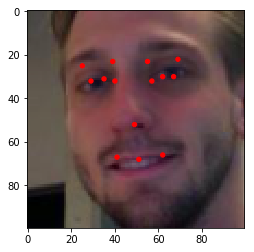

In [81]:
# Example of output
from random import randint
i = randint(0, 599)
img = imgs_val[i:i+1]
img_points = points_val[i:i+1]
pred_points = model.predict(img)[0]
visualize_points(img[0], pred_points)
print((pred_points+0.5)*100)

In [82]:
print (aug_points_train[0])

[-0.34670487 -0.14469914 -0.20200573 -0.27793697 -0.05730659 -0.34097421
  0.21060172 -0.34527221 -0.29799426 -0.06446991 -0.21776505 -0.1017192
 -0.1661891  -0.13753581  0.02148997 -0.21346705  0.09742121 -0.23352435
  0.17048711 -0.24928367 -0.11031519 -0.08452722 -0.13037249  0.21489972
 -0.01432665  0.12750717  0.1461318   0.10744986]


In [83]:
predicted_keypoints=model.predict(imgs_val)

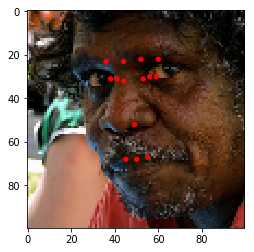

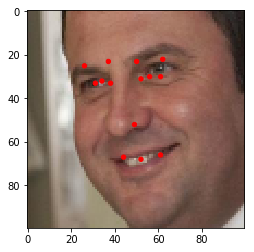

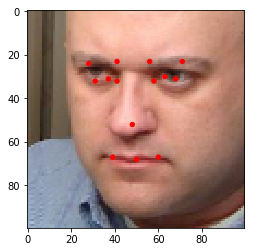

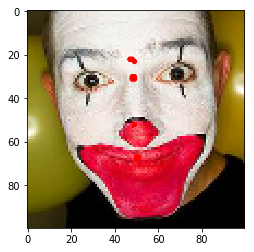

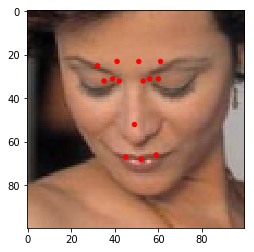

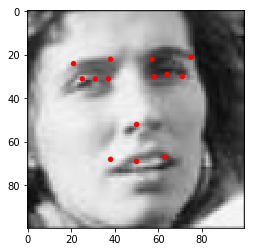

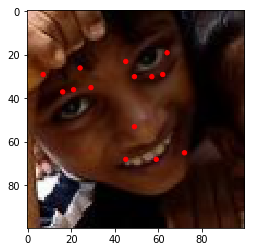

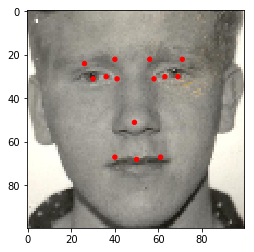

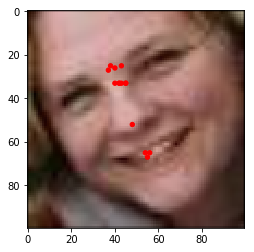

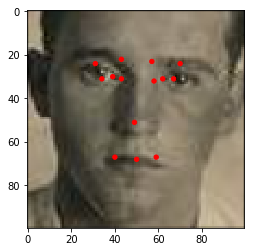

In [88]:
for i in range(10):
    ix=np.random.choice(range(imgs_val.shape[0]))
    visualize_points(imgs_val[ix],predicted_keypoints[ix])